# Setup

In [1]:
import mlflow
import mlflow.sklearn
from joblib import dump
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import ExponentiatedGradientReduction
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from aif360.metrics import ClassificationMetric
from sklearn.base import clone
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load Data

In [7]:
train_data = pd.read_parquet('./data/train_scaled.parquet')
test_data = pd.read_parquet('./data/test_scaled.parquet')

In [8]:
train_data.columns

Index(['purchase_value', 'age', 'ip_address', 'signup_month', 'signup_day',
       'signup_hour', 'signup_weekday', 'signup_hour_sin', 'signup_hour_cos',
       'purchase_month', 'purchase_day', 'purchase_hour', 'purchase_weekday',
       'purchase_hour_sin', 'purchase_hour_cos', 'time_diff', 'source_Direct',
       'source_SEO', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_M', 'country_encoded', 'class'],
      dtype='object')

# Prepare Data

In [9]:
# Get the mean and std of age from training for reversing scaling (from the other notebook)
age_mean_train = 33.028
age_std_train = 8.454
age_mean_test = 33.079
age_std_test = 8.473

In [10]:
# Reverse scaling for age in train and test datasets
train_data['age'] = train_data['age'] * age_std_train + age_mean_train
test_data['age'] = test_data['age'] * age_std_test + age_mean_test

In [11]:
# Define protected attribute based on age group
train_data['age_group'] = np.where((train_data['age'] >= 30) & (train_data['age'] <= 40), 1, 0)  # Privileged: 30-40
test_data['age_group'] = np.where((test_data['age'] >= 30) & (test_data['age'] <= 40), 1, 0)  # Unprivileged: others

# Convert sex_M to int for consistency
train_data['sex_M'] = train_data['sex_M'].astype(int) # Privileged: Male
test_data['sex_M'] = test_data['sex_M'].astype(int) # Unprivileged: Others

In [12]:
train_data = train_data.drop(columns=['age'])
test_data = test_data.drop(columns=['age'])

In [13]:
# Split features and target
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']
X_test = test_data.drop(columns=['class'])
y_test = test_data['class']

In [14]:
# Define protected attributes
protected_attributes = ['sex_M', 'age_group']

In [15]:
def create_aif_dataset(X, y, protected_attribute, privileged_value):
    dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pd.concat([X, y], axis=1),
        label_names=['class'],
        protected_attribute_names=[protected_attribute],
        privileged_protected_attributes=[[privileged_value]]
    )
    return dataset

# Measure Performance with Mitigators

In [16]:
def evaluate_accuracy_metrics(y_true, y_pred):
    """Calculate accuracy metrics."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred)
    }

In [17]:
def calculate_fairness_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups):
    """Compute fairness metrics using AIF360."""
    metric = ClassificationMetric(dataset_true, dataset_pred,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    return {
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Disparate Impact": metric.disparate_impact()
    }

In [18]:
models = {
    'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=300),
    'GradientBoosting': GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=300),
    'LightGBM': LGBMClassifier(learning_rate=0.1, n_estimators=300, num_leaves=63)
}

In [19]:
results = {}

In [20]:
mitigators = ['Baseline', 'Reweighing', 'EGR', 'CalibratedEqualizedOdds']

# Baseline (No Mitigator)

In [21]:
results['Baseline'] = {}

In [22]:
for model_name, model in models.items():
    for attribute in protected_attributes:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"Baseline_{model_name}_{attribute}"):
            mlflow.log_param("scenario", "Baseline")
            mlflow.log_param("model", model_name)
            mlflow.log_param("protected_attribute", attribute)

        print(f"Baseline - Model: {model_name}, Attribute: {attribute}")

        # Fit model
        start_time = time.time()
        model.fit(X_train, y_train)
        baseline_time = time.time() - start_time

        # Predictions
        y_pred = model.predict(X_test)

        # Fairness
        train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                           label_names=['class'],
                                           protected_attribute_names=[attribute])
        test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                          label_names=['class'],
                                          protected_attribute_names=[attribute])
        pred_dataset = test_dataset.copy()
        pred_dataset.labels = y_pred

        fairness_metrics = calculate_fairness_metrics(test_dataset, pred_dataset,
                                              [{attribute: 1}], [{attribute: 0}])
        accuracy_metrics = evaluate_accuracy_metrics(y_test, y_pred)

        # Save results
        results['Baseline'][(model_name, attribute)] = {
            'Accuracy Metrics': accuracy_metrics,
            'Fairness Metrics': fairness_metrics,
            'Training Time': baseline_time
        }

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy_metrics['Accuracy'])
        mlflow.log_metric("f1_score", accuracy_metrics['F1-Score'])
        mlflow.log_metric("precision", accuracy_metrics['Precision'])
        mlflow.log_metric("recall", accuracy_metrics['Recall'])

        mlflow.log_metric("statistical_parity_difference", fairness_metrics['Statistical Parity Difference'])
        mlflow.log_metric("disparate_impact", fairness_metrics['Disparate Impact'])

        mlflow.log_metric("training_time", baseline_time)

Baseline - Model: XGBoost, Attribute: sex_M
Baseline - Model: XGBoost, Attribute: age_group
Baseline - Model: GradientBoosting, Attribute: sex_M
Baseline - Model: GradientBoosting, Attribute: age_group
Baseline - Model: LightGBM, Attribute: sex_M
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093687 -> initscore=-2.269421
[LightGBM] [Info] Start training from score -2.269421
Baseline - Model: LightGBM, Attribute: age_group
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of

# Preprocessing Mitigator: Reweighing

In [23]:
results['Reweighing'] = {}

In [24]:
for model_name, model in models.items():
    for attribute in protected_attributes:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"Reweighing_{model_name}_{attribute}"):
            mlflow.log_param("scenario", "Reweighing")
            mlflow.log_param("model", model_name)
            mlflow.log_param("protected_attribute", attribute)

        print(f"Reweighing - Model: {model_name}, Attribute: {attribute}")

        # Reweighing transformation
        reweighing = Reweighing(unprivileged_groups=[{attribute: 0}],
                                privileged_groups=[{attribute: 1}])
        train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                           label_names=['class'],
                                           protected_attribute_names=[attribute])
        test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                          label_names=['class'],
                                          protected_attribute_names=[attribute])
        start_time = time.time()
        train_rw = reweighing.fit_transform(train_dataset)
        model_rw = clone(model)
        model_rw.fit(train_rw.features, train_rw.labels.ravel(), sample_weight=train_rw.instance_weights)
        rw_time = time.time() - start_time

        # Predictions
        y_pred_rw = model_rw.predict(X_test)
        pred_dataset = test_dataset.copy()
        pred_dataset.labels = y_pred_rw

        # Fairness and Accuracy
        fairness_rw = calculate_fairness_metrics(test_dataset, pred_dataset,
                                                 [{attribute: 1}], [{attribute: 0}])
        accuracy_rw = evaluate_accuracy_metrics(y_test, y_pred_rw)

        # Save results
        results['Reweighing'][(model_name, attribute)] = {
            'Accuracy Metrics': accuracy_rw,
            'Fairness Metrics': fairness_rw,
            'Training Time': rw_time
        }

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy_rw['Accuracy'])
        mlflow.log_metric("f1_score", accuracy_rw['F1-Score'])
        mlflow.log_metric("precision", accuracy_rw['Precision'])
        mlflow.log_metric("recall", accuracy_rw['Recall'])

        mlflow.log_metric("statistical_parity_difference", fairness_rw['Statistical Parity Difference'])
        mlflow.log_metric("disparate_impact", fairness_rw['Disparate Impact'])

        mlflow.log_metric("training_time", rw_time)

Reweighing - Model: XGBoost, Attribute: sex_M
Reweighing - Model: XGBoost, Attribute: age_group
Reweighing - Model: GradientBoosting, Attribute: sex_M


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Reweighing - Model: GradientBoosting, Attribute: age_group


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Reweighing - Model: LightGBM, Attribute: sex_M
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093687 -> initscore=-2.269421
[LightGBM] [Info] Start training from score -2.269421
Reweighing - Model: LightGBM, Attribute: age_group
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [

# Inprocessing Mitigator: Exponentiated Gradient Reduction

In [25]:
results['EGR'] = {}

In [26]:
for model_name, model in models.items():
    for attribute in protected_attributes:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"EGR_{model_name}_{attribute}"):
            mlflow.log_param("scenario", "EGR")
            mlflow.log_param("model", model_name)
            mlflow.log_param("protected_attribute", attribute)

        print(f"EGR - Model: {model_name}, Attribute: {attribute}")
        train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                           label_names=['class'],
                                           protected_attribute_names=[attribute])
        test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                          label_names=['class'],
                                          protected_attribute_names=[attribute])

        start_time = time.time()
        egr = ExponentiatedGradientReduction(model, constraints='EqualizedOdds')
        egr.fit(train_dataset)
        pred_dataset = egr.predict(test_dataset)
        egr_time = time.time() - start_time

        # Fairness and Accuracy
        fairness_egr = calculate_fairness_metrics(test_dataset, pred_dataset,
                                                  [{attribute: 1}], [{attribute: 0}])
        accuracy_egr = evaluate_accuracy_metrics(y_test, pred_dataset.labels)

        # Save results
        results['EGR'][(model_name, attribute)] = {
            'Accuracy Metrics': accuracy_egr,
            'Fairness Metrics': fairness_egr,
            'Training Time': egr_time
        }

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy_egr['Accuracy'])
        mlflow.log_metric("f1_score", accuracy_egr['F1-Score'])
        mlflow.log_metric("precision", accuracy_egr['Precision'])
        mlflow.log_metric("recall", accuracy_egr['Recall'])

        mlflow.log_metric("statistical_parity_difference", fairness_egr['Statistical Parity Difference'])
        mlflow.log_metric("disparate_impact", fairness_egr['Disparate Impact'])

        mlflow.log_metric("training_time", egr_time)

EGR - Model: XGBoost, Attribute: sex_M


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


EGR - Model: XGBoost, Attribute: age_group


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


EGR - Model: GradientBoosting, Attribute: sex_M


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


EGR - Model: GradientBoosting, Attribute: age_group


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


EGR - Model: LightGBM, Attribute: sex_M


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093687 -> initscore=-2.269421
[LightGBM] [Info] Start training from score -2.269421
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 23
[LightGBM] [Info

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093687 -> initscore=-2.269421
[LightGBM] [Info] Start training from score -2.269421
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 23
[LightGBM] [Info

# Postprocessing Mitigator: CalibratedEqualizedOdds

In [27]:
results['CalibratedEqualizedOdds'] = {}

In [28]:
for model_name, model in models.items():
    for attribute in protected_attributes:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"CalibratedEqualizedOdds_{model_name}_{attribute}"):
            mlflow.log_param("scenario", "CalibratedEqualizedOdds")
            mlflow.log_param("model", model_name)
            mlflow.log_param("protected_attribute", attribute)

        print(f"Postprocessing - Model: {model_name}, Attribute: {attribute}")

        # Transform data
        train_dataset = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1),
                                           label_names=['class'],
                                           protected_attribute_names=[attribute])
        test_dataset = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1),
                                          label_names=['class'],
                                          protected_attribute_names=[attribute])

        # Fit the baseline model on training data
        model.fit(X_train, y_train)

        # Split the test dataset into validation and final test sets for CEO calibration
        valid_dataset, final_test_dataset = test_dataset.split([0.5], shuffle=True)

        # Obtain predictions on the validation dataset
        y_pred_valid = model.predict(valid_dataset.features)
        y_pred_scores_valid = model.predict_proba(valid_dataset.features)[:, 1]

        # Create a predicted dataset for the validation set
        pred_dataset = valid_dataset.copy(deepcopy=True)
        pred_dataset.labels = y_pred_valid
        pred_dataset.scores = y_pred_scores_valid.reshape(-1, 1)

        # Apply Calibrated Equalized Odds
        start_time = time.time()
        ceo = CalibratedEqOddsPostprocessing(
            unprivileged_groups=[{attribute: 0}],
            privileged_groups=[{attribute: 1}],
            cost_constraint="fnr"
        )
        ceo.fit(valid_dataset, pred_dataset)

        # Apply CEO on the final test dataset
        test_pred_ceo = ceo.predict(final_test_dataset)
        ceo_time = time.time() - start_time

        # Compute fairness and accuracy metrics
        fairness_ceo = calculate_fairness_metrics(final_test_dataset, test_pred_ceo,
                                                  [{attribute: 1}], [{attribute: 0}])
        accuracy_ceo = evaluate_accuracy_metrics(final_test_dataset.labels.ravel(), test_pred_ceo.labels.ravel())

        # Save results
        results['CalibratedEqualizedOdds'][(model_name, attribute)] = {
            'Accuracy Metrics': accuracy_ceo,
            'Fairness Metrics': fairness_ceo,
            'Training Time': ceo_time
        }

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy_ceo['Accuracy'])
        mlflow.log_metric("f1_score", accuracy_ceo['F1-Score'])
        mlflow.log_metric("precision", accuracy_ceo['Precision'])
        mlflow.log_metric("recall", accuracy_ceo['Recall'])

        mlflow.log_metric("statistical_parity_difference", fairness_ceo['Statistical Parity Difference'])
        mlflow.log_metric("disparate_impact", fairness_ceo['Disparate Impact'])

        mlflow.log_metric("training_time", ceo_time)

Postprocessing - Model: XGBoost, Attribute: sex_M
Postprocessing - Model: XGBoost, Attribute: age_group
Postprocessing - Model: GradientBoosting, Attribute: sex_M


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Postprocessing - Model: GradientBoosting, Attribute: age_group


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Postprocessing - Model: LightGBM, Attribute: sex_M
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 119760, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093687 -> initscore=-2.269421
[LightGBM] [Info] Start training from score -2.269421
Postprocessing - Model: LightGBM, Attribute: age_group
[LightGBM] [Info] Number of positive: 11220, number of negative: 108540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[Lig

# Visualization

In [29]:
# Flatten the results for visualization
visualization_data = []
for mitigator, mitigator_results in results.items():
    for (model_name, attribute), metrics in mitigator_results.items():
        visualization_data.append({
            "Mitigator": mitigator,
            "Model": model_name,
            "Attribute": attribute,
            "Accuracy": metrics['Accuracy Metrics']['Accuracy'],
            "F1-Score": metrics['Accuracy Metrics']['F1-Score'],
            "Statistical Parity Difference": metrics['Fairness Metrics']['Statistical Parity Difference'],
            "Disparate Impact": metrics['Fairness Metrics']['Disparate Impact'],
            "Training Time": metrics['Training Time']
        })

df_results = pd.DataFrame(visualization_data)

In [35]:
df_results

,Mitigator,Model,Attribute,Accuracy,F1-Score,Statistical Parity Difference,Disparate Impact,Training Time
0,Baseline,XGBoost,sex_M,0.955913,0.692594,-0.004301,0.916527,5.792574
1,Baseline,XGBoost,age_group,0.955913,0.692594,-0.009054,0.835770,2.422246
2,Baseline,GradientBoosting,sex_M,0.955312,0.689991,-0.004598,0.912215,174.232537
3,Baseline,GradientBoosting,age_group,0.955479,0.690504,-0.008327,0.848972,161.612079
4,Baseline,LightGBM,sex_M,0.955980,0.692917,-0.004186,0.918568,3.053247
5,Baseline,LightGBM,age_group,0.955980,0.692917,-0.008889,0.838287,4.524967
6,Reweighing,XGBoost,sex_M,0.955947,0.692756,-0.004244,0.917546,5.644974
7,Reweighing,XGBoost,age_group,0.955947,0.692756,-0.008833,0.839306,18.907699
8,Reweighing,GradientBoosting,sex_M,0.955145,0.689192,-0.004335,0.917335,169.000614
9,Reweighing,GradientBoosting,age_group,0.955680,0.691611,-0.008689,0.842629,167.746688


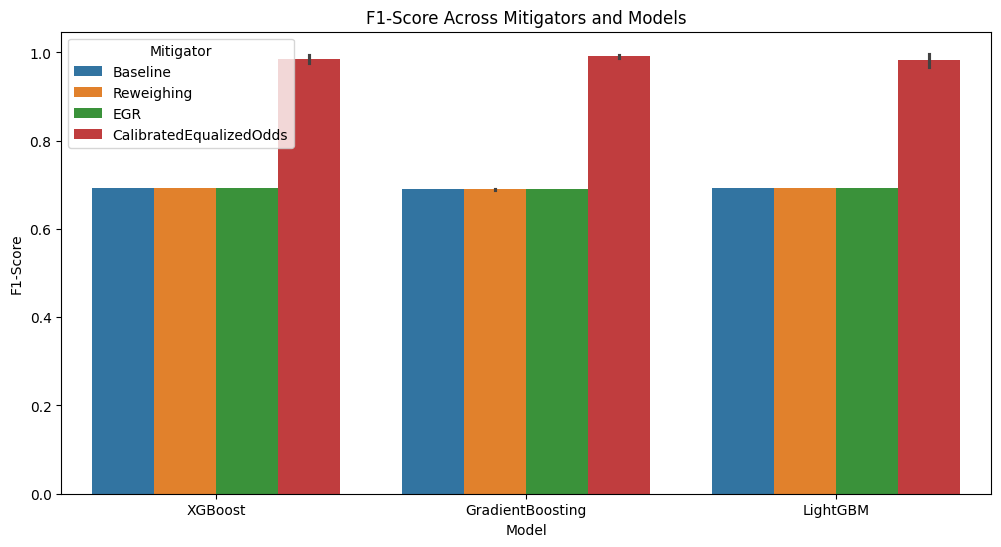

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="F1-Score", hue="Mitigator")
plt.title("F1-Score Across Mitigators and Models")
plt.show()

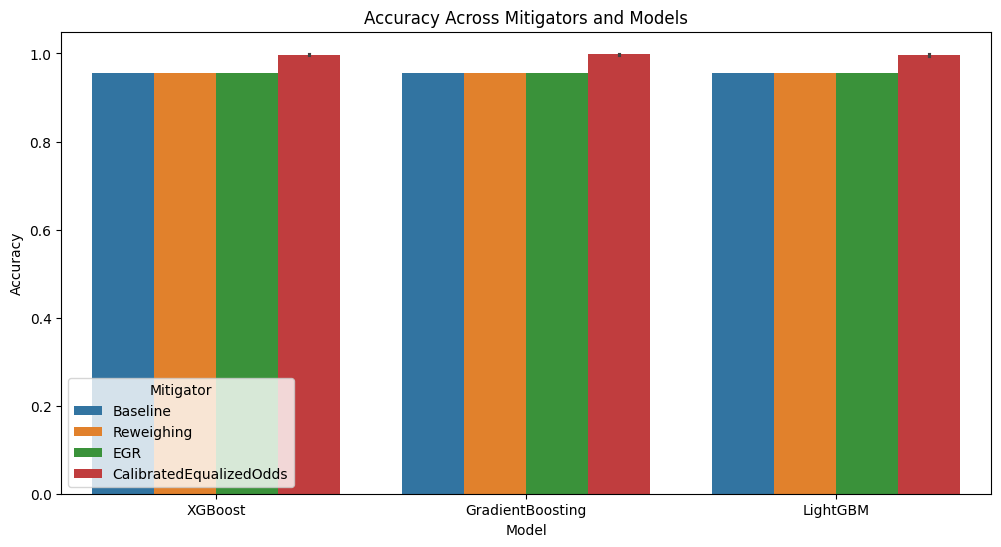

In [21]:
# Visualization: Accuracy Across Mitigators and Models
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="Accuracy", hue="Mitigator")
plt.title("Accuracy Across Mitigators and Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.legend(title="Mitigator")
plt.show()

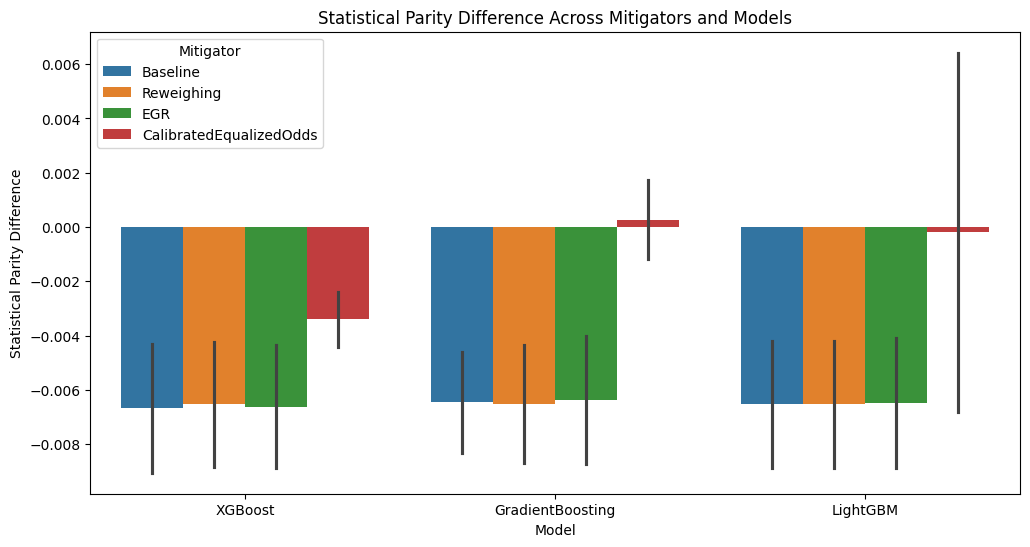

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="Statistical Parity Difference", hue="Mitigator")
plt.title("Statistical Parity Difference Across Mitigators and Models")
plt.show()

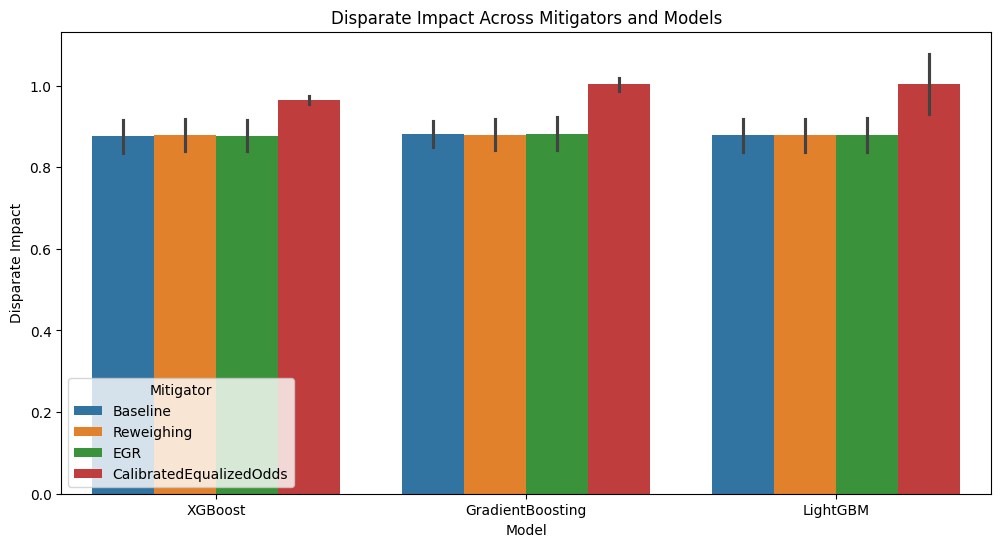

In [22]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="Disparate Impact", hue="Mitigator")
plt.title("Disparate Impact Across Mitigators and Models")
plt.xlabel("Model")
plt.ylabel("Disparate Impact")
plt.legend(title="Mitigator")
plt.show()

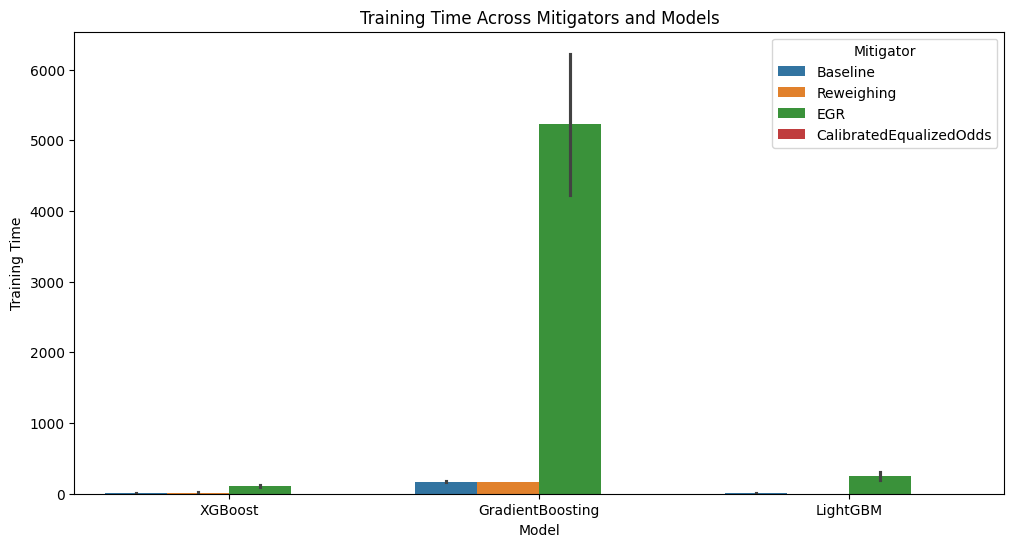

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="Training Time", hue="Mitigator")
plt.title("Training Time Across Mitigators and Models")
plt.show()